# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [89]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [90]:
features = ['radius_mean', 'texture_mean']

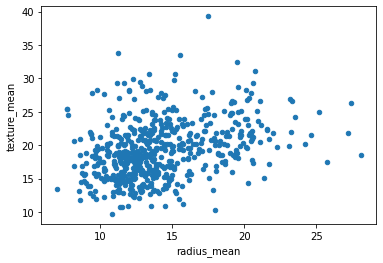

In [91]:
df[features].plot(kind='scatter', x=features[0], y=features[1]);

In [92]:
# Initialize instance of KMeans class from sklearn
k = 3
model = KMeans(n_clusters=k, max_iter=1)

In [93]:
# fit the instantiated model to our dataframe
model.fit(df[features].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [94]:
# assign clusters back to our dataframe
df['cluster'] = model.labels_

In [95]:
# Get our centroids
centroids = model.cluster_centers_

In [96]:
# turn them into a dataframe
cc = pd.DataFrame(centroids)
cc.head()

,0,1
0,12.325788,17.196584
1,18.906619,21.091655
2,13.972358,26.891194


In [97]:
# setup colors for plotting
base_colors = ['r', 'g', 'b']
colors = [base_colors[centroid] for centroid in model.labels_]

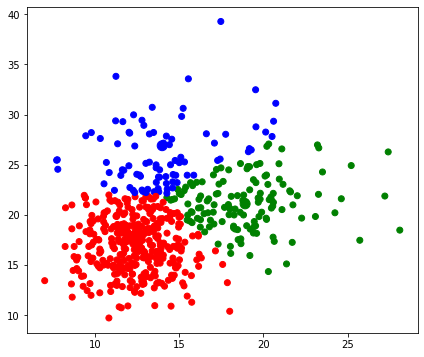

In [98]:
# plot the scatter of our points with calculated centroids
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(df[features[0]], df[features[1]], c=colors)
ax.scatter(cc[0], cc[1], c=base_colors, s=100);

In [99]:
# import metrics
from sklearn import metrics

In [100]:
# drop column
df = df.drop('Unnamed: 32', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,cluster
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [101]:
# silhouette score
metrics.silhouette_score(df, model.labels_, metric='euclidean')

0.017089750246457324

In [39]:
model.labels_

array([1, 2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 2, 2, 1, 0, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 1, 0, 1, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 0, 1, 2, 2, 1, 2, 0, 2,
       0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 2, 1, 0,
       0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 2, 0, 1, 1, 0, 2, 2, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 2, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2,
       2, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2, 0, 2, 1, 1,
       1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 1, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2,

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [103]:
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")

In [108]:
df_diag = df['diagnosis']
df_diag = pd.DataFrame(df_diag)
df_diag.head()

,diagnosis
0,M
1,M
2,M
3,M
4,M


In [115]:
df_diag['Diagnosis'] = np.where(df_diag['diagnosis']=='M', 1, 0)

IndexError: ignored

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [ ]:
##### Your Code Here #####

In [44]:
# read back in the data
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv", index_col=0)

In [64]:
df = df.drop('Unnamed: 32', axis=1)
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [65]:
features = list(df.columns)
features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [66]:
# instantiate the SKLearn class for standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [67]:
# Standardize dataset
scaled_data = scaler.fit_transform(df)

In [68]:
scaled_data[:5]

array([[ 1.09706398e+00, -2.07333501e+00,  1.26993369e+00,
         9.84374905e-01,  1.56846633e+00,  3.28351467e+00,
         2.65287398e+00,  2.53247522e+00,  2.21751501e+00,
         2.25574689e+00,  2.48973393e+00, -5.65265059e-01,
         2.83303087e+00,  2.48757756e+00, -2.14001647e-01,
         1.31686157e+00,  7.24026158e-01,  6.60819941e-01,
         1.14875667e+00,  9.07083081e-01,  1.88668963e+00,
        -1.35929347e+00,  2.30360062e+00,  2.00123749e+00,
         1.30768627e+00,  2.61666502e+00,  2.10952635e+00,
         2.29607613e+00,  2.75062224e+00,  1.93701461e+00],
       [ 1.82982061e+00, -3.53632408e-01,  1.68595471e+00,
         1.90870825e+00, -8.26962447e-01, -4.87071673e-01,
        -2.38458552e-02,  5.48144156e-01,  1.39236330e-03,
        -8.68652457e-01,  4.99254601e-01, -8.76243603e-01,
         2.63326966e-01,  7.42401948e-01, -6.05350847e-01,
        -6.92926270e-01, -4.40780058e-01,  2.60162067e-01,
        -8.05450380e-01, -9.94437403e-02,  1.80592744e+

In [69]:
df_scaled = pd.DataFrame(scaled_data, columns=features)
df_scaled.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [70]:
df_scaled.mean()

radius_mean               -1.256562e-16
texture_mean               1.049736e-16
perimeter_mean            -1.272171e-16
area_mean                 -1.900452e-16
smoothness_mean            1.490704e-16
compactness_mean           2.544342e-16
concavity_mean            -1.338511e-16
concave points_mean       -8.429110e-17
symmetry_mean              2.081912e-16
fractal_dimension_mean     5.408679e-16
radius_se                  2.475807e-16
texture_se                -9.912009e-17
perimeter_se              -2.968237e-16
area_se                   -1.088760e-16
smoothness_se              4.426014e-16
compactness_se             1.958988e-16
concavity_se               1.678017e-16
concave points_se          2.185325e-17
symmetry_se                1.523874e-16
fractal_dimension_se      -5.658430e-17
radius_worst              -7.988142e-16
texture_worst             -1.834112e-17
perimeter_worst           -4.015534e-16
area_worst                -2.848727e-17
smoothness_worst          -2.189227e-16


In [71]:
df_scaled[features].std()

radius_mean                1.00088
texture_mean               1.00088
perimeter_mean             1.00088
area_mean                  1.00088
smoothness_mean            1.00088
compactness_mean           1.00088
concavity_mean             1.00088
concave points_mean        1.00088
symmetry_mean              1.00088
fractal_dimension_mean     1.00088
radius_se                  1.00088
texture_se                 1.00088
perimeter_se               1.00088
area_se                    1.00088
smoothness_se              1.00088
compactness_se             1.00088
concavity_se               1.00088
concave points_se          1.00088
symmetry_se                1.00088
fractal_dimension_se       1.00088
radius_worst               1.00088
texture_worst              1.00088
perimeter_worst            1.00088
area_worst                 1.00088
smoothness_worst           1.00088
compactness_worst          1.00088
concavity_worst            1.00088
concave points_worst       1.00088
symmetry_worst      

In [58]:
# import and instantiate the PCA class
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [72]:
# apply PCA
pca_features = pca.fit_transform(df_scaled)
pca_features[:5]

array([[ 9.19283683,  1.94858307],
       [ 2.3878018 , -3.76817174],
       [ 5.73389628, -1.0751738 ],
       [ 7.1229532 , 10.27558912],
       [ 3.93530207, -1.94807157]])

In [73]:
# how much variation did each principal component explain?
pca.explained_variance_ratio_

array([0.44272026, 0.18971182])

In [75]:
# how much total variance did we explain?
sum(pca.explained_variance_ratio_)

0.6324320765155943

In [74]:
# how much info did we lose?
1-sum(pca.explained_variance_ratio_)

0.3675679234844057

In [76]:
# turn into a dataframe
df_pca = pd.DataFrame(pca_features, columns=['comp_1', 'comp_2'])
df_pca.head()

,comp_1,comp_2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072


In [77]:
# initialize an instance of the KMeans class from sklearn
k = 3
model = KMeans(n_clusters=k, max_iter=1)

In [78]:
# fit instantiated model to our dataframe
model.fit(df_pca.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [79]:
# assign predicted clusters back to our dataframe
df_pca['cluster'] = model.labels_

In [80]:
# get centroids
centroids = model.cluster_centers_

In [81]:
# turn into dataframe
cc = pd.DataFrame(centroids)
cc.head()

,0,1
0,5.317557,-1.539816
1,-2.030723,-0.222233
2,2.430164,4.273687


In [82]:
# setup for plotting
base_colors = ['r', 'g', 'b']
colors = [base_colors[centroid] for centroid in model.labels_]

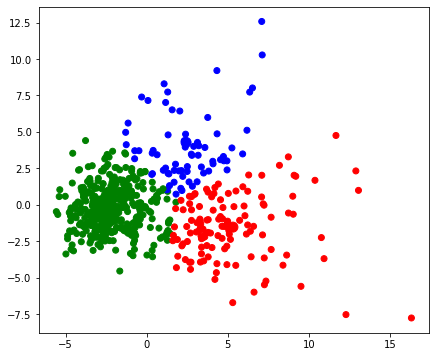

In [83]:
# plot scatter of our points with calculated centroids
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(df_pca['comp_1'], df_pca['comp_2'], c=colors)
ax.scatter(cc[0], cc[1], c=base_colors, s=100);

In [85]:
# silhouette score
metrics.silhouette_score(df, model.labels_, metric='euclidean')

0.16672553865903092

In [86]:
# what is predicted centroid for each data point?
model.labels_

array([0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 0, 1, 2, 2, 1, 0, 0, 1, 1, 1,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 0,
       1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1,
       0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       2, 1, 0, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [ ]:
# Your Code Here

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project